# Features 

In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = '../../data' #You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

## Features per Dimension 

- Effort        ->  weekly_clicks, weekly_time_spent
- Consistency   ->  mean_session_duration, std_weekly_activity
- Regularity    ->  mean_days_between_sessions
- Proactivity   ->  go_to_theory_actions, early_sessions
- Control       ->  weekly_next_actions, weekly_skip_actions
- Assessment     ->  weekly_percentage_correct, challenges_completed

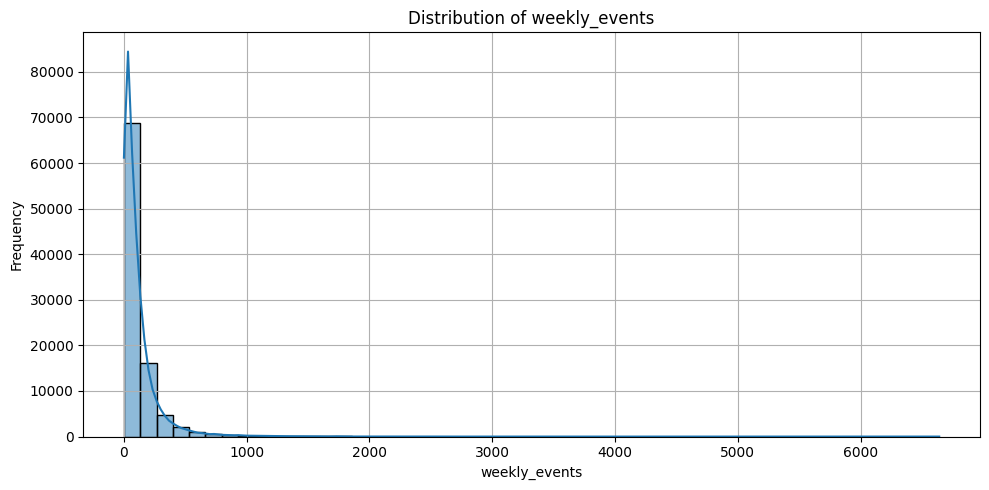

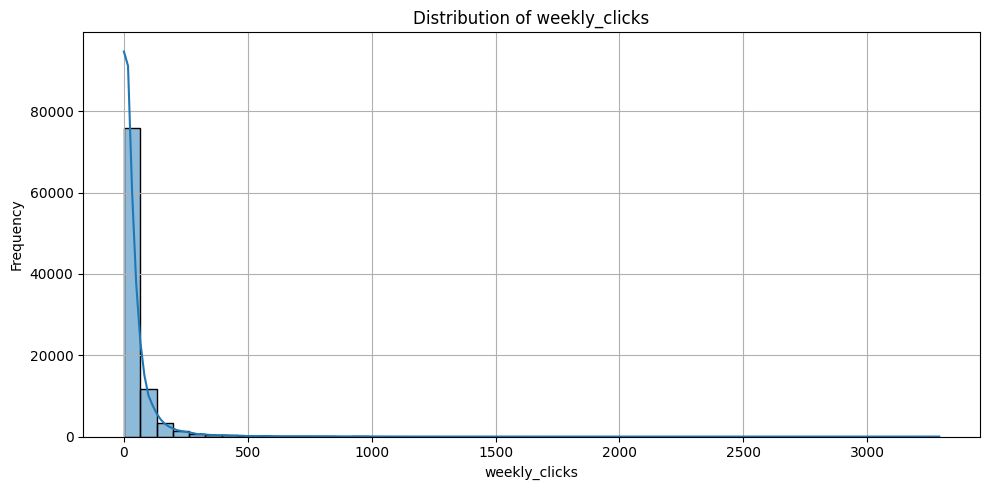

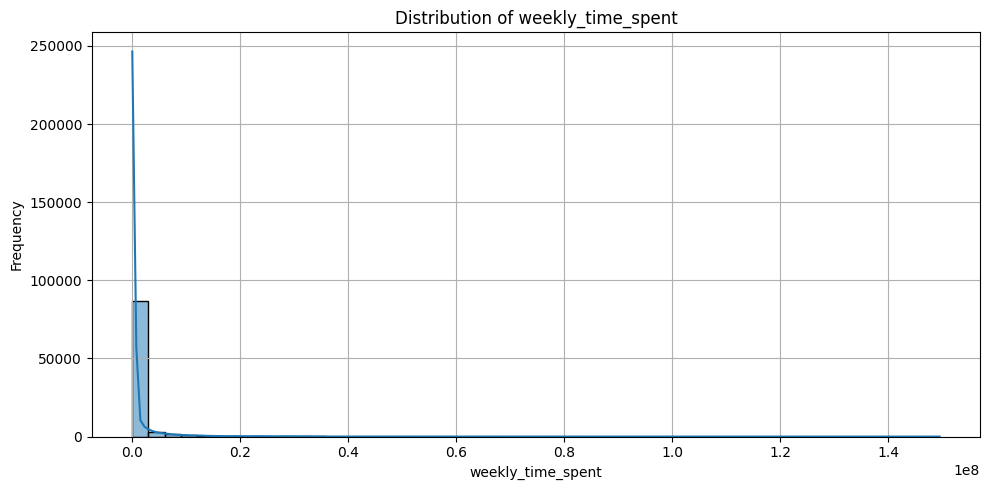

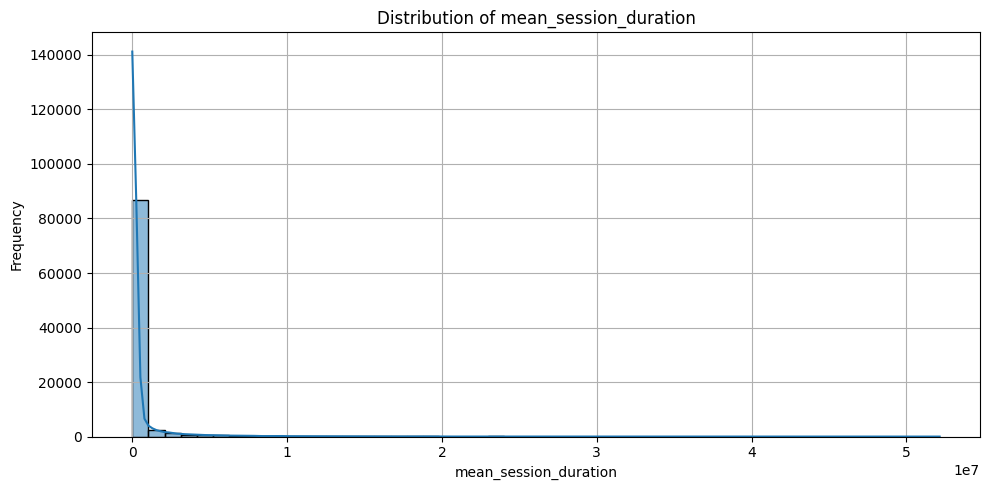

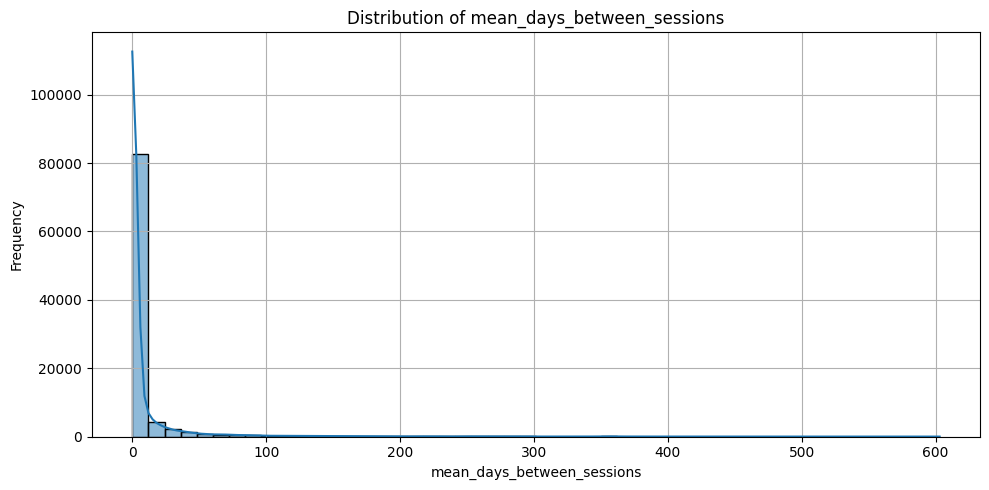

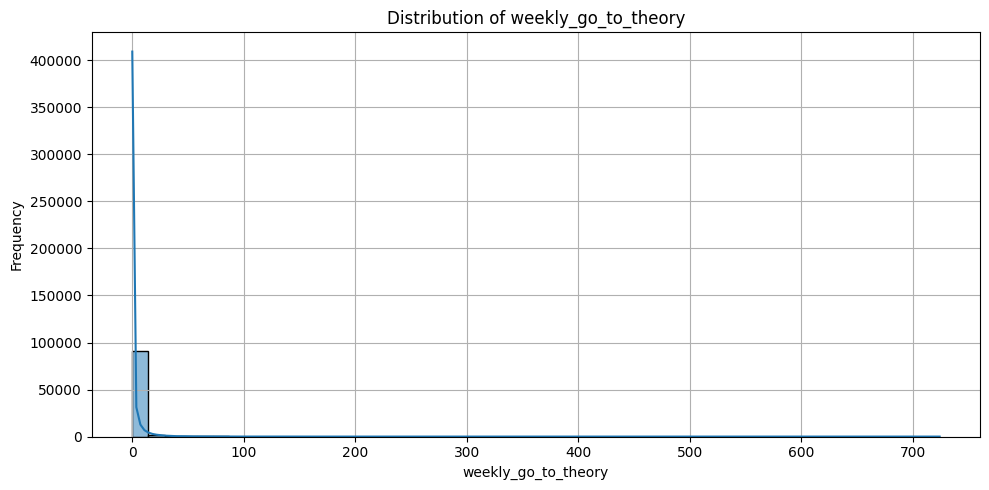

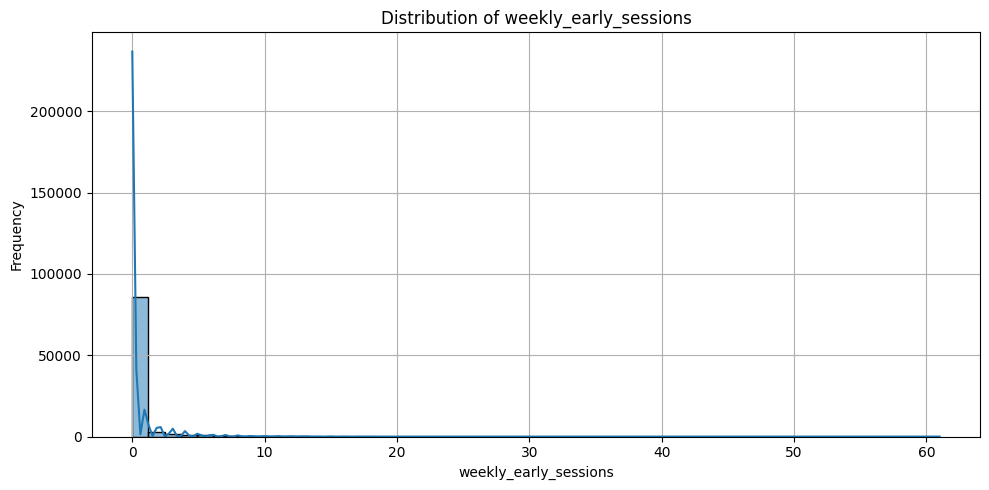

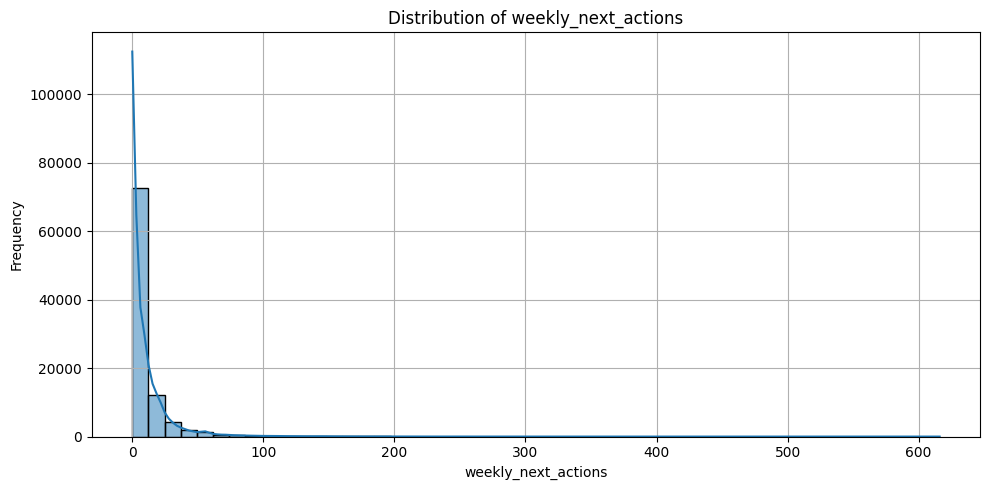

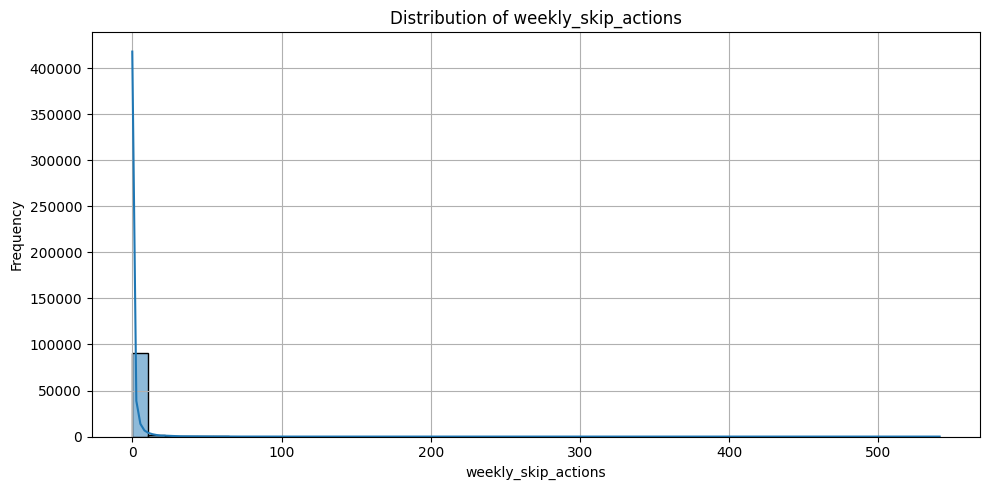

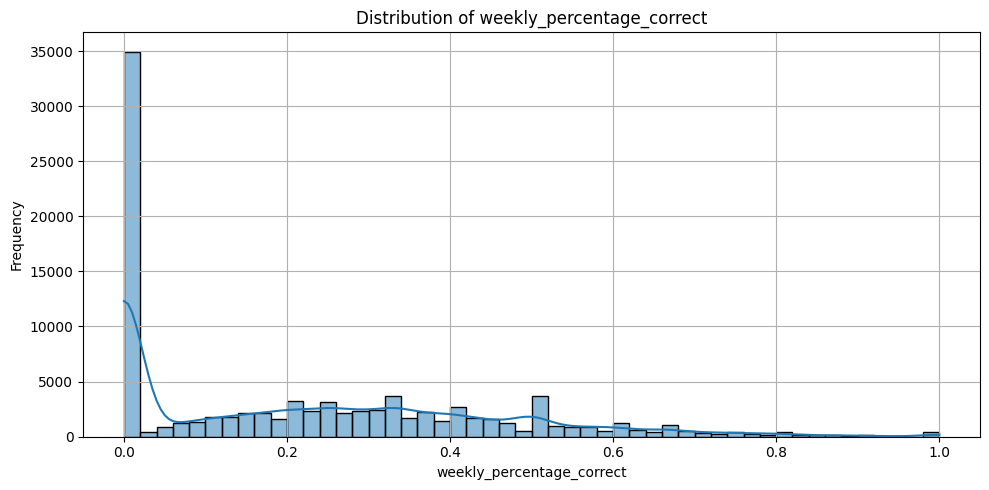

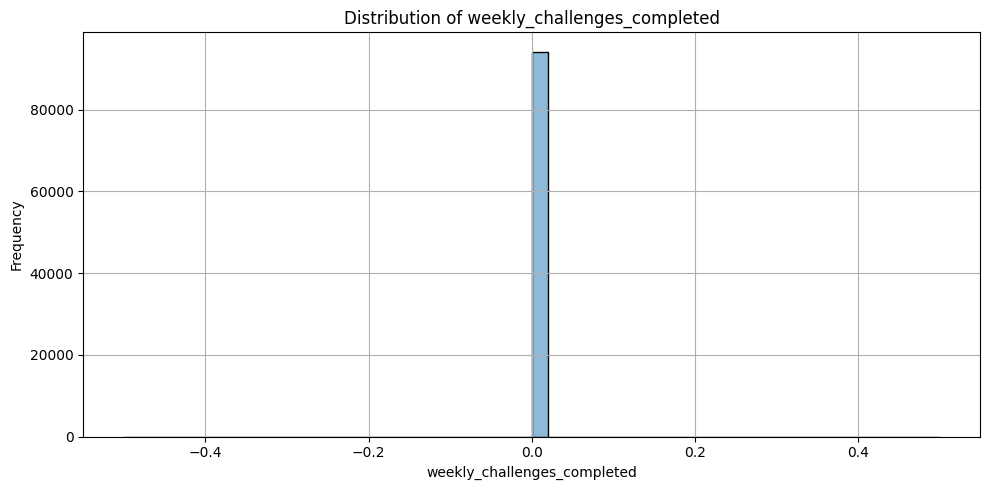

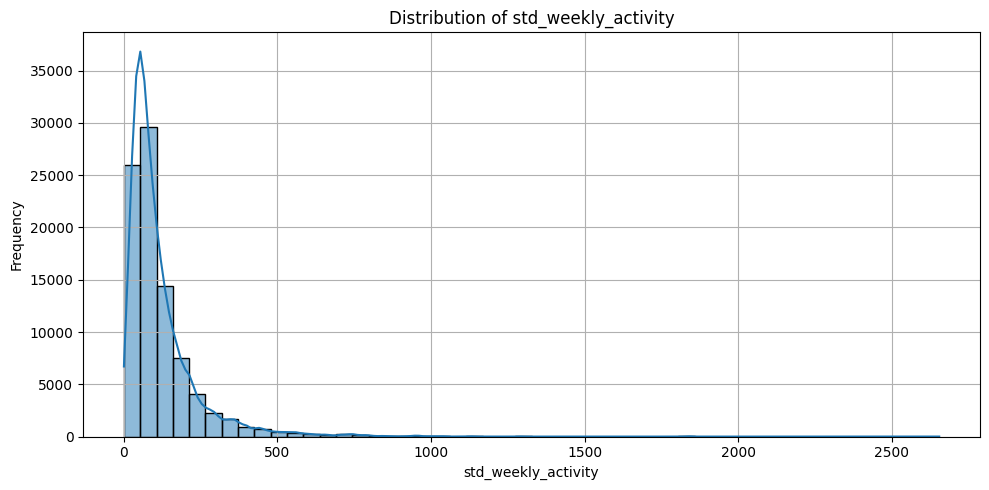

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert event_date and start_time to datetime
events['date'] = pd.to_datetime(events['event_date'])
transactions['date'] = pd.to_datetime(transactions['start_time'])

# Extract year and week number
events['year_week'] = events['date'].dt.strftime('%Y-%U')
transactions['year_week'] = transactions['date'].dt.strftime('%Y-%U')

# Effort
weekly_events = events.groupby(['user_id', 'year_week']).size().reset_index(name='weekly_events')
weekly_clicks = events[events['event_type'] == 'CLICK'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_clicks')

# Time spent per session
events = events.sort_values(by=['user_id', 'date'])
events['next_date'] = events.groupby(['user_id', 'session_id'])['date'].shift(-1)
events['session_time'] = (events['next_date'] - events['date']).dt.total_seconds()
weekly_time_spent = events.groupby(['user_id', 'year_week'])['session_time'].sum().reset_index(name='weekly_time_spent')

# Consistency
session_durations = events.groupby(['user_id', 'session_id']).agg(
    session_start=('date', 'min'),
    session_end=('date', 'max')
).reset_index()
session_durations['duration'] = (session_durations['session_end'] - session_durations['session_start']).dt.total_seconds()
session_durations['year_week'] = session_durations['session_start'].dt.strftime('%Y-%U')
mean_session_duration = session_durations.groupby(['user_id', 'year_week'])['duration'].mean().reset_index(name='mean_session_duration')

std_weekly_activity = weekly_events.groupby('user_id')['weekly_events'].std().reset_index(name='std_weekly_activity')

# Regularity
session_starts = events.groupby(['user_id', 'session_id'])['date'].min().reset_index()
session_starts = session_starts.sort_values(by=['user_id', 'date'])
session_starts['previous_session'] = session_starts.groupby('user_id')['date'].shift(1)
session_starts['days_between'] = (session_starts['date'] - session_starts['previous_session']).dt.days
session_starts['year_week'] = session_starts['date'].dt.strftime('%Y-%U')
mean_days_between_sessions = session_starts.groupby(['user_id', 'year_week'])['days_between'].mean().reset_index(name='mean_days_between_sessions')

# Proactivity
go_to_theory_actions = events[events['action'] == 'GO_TO_THEORY'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_go_to_theory')
events['hour'] = events['date'].dt.hour
early_sessions = events[events['hour'] < 8].groupby(['user_id', 'year_week'])['session_id'].nunique().reset_index(name='weekly_early_sessions')

# Control
next_actions = events[events['action'] == 'NEXT'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_next_actions')
skip_actions = events[events['action'] == 'SKIP'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_skip_actions')

# Assessment
correct_evaluations = transactions[transactions['evaluation'] == 'CORRECT'].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_correct')
total_evaluations = transactions.groupby(['user_id', 'year_week']).size().reset_index(name='weekly_total')
assessment = pd.merge(total_evaluations, correct_evaluations, on=['user_id', 'year_week'], how='left').fillna(0)
assessment['weekly_percentage_correct'] = assessment['weekly_correct'] / assessment['weekly_total']

challenges_completed = transactions[transactions['challenge_id'].notnull() & (transactions['session_accepted'] == 1)].groupby(['user_id', 'year_week']).size().reset_index(name='weekly_challenges_completed')

# Combine all features
user_week_features = pd.DataFrame(events[['user_id', 'year_week']].drop_duplicates())

feature_dfs = [
    weekly_events, weekly_clicks, weekly_time_spent, mean_session_duration,
    mean_days_between_sessions, go_to_theory_actions,
    early_sessions, next_actions, skip_actions,
    assessment[['user_id', 'year_week', 'weekly_percentage_correct']], challenges_completed
]

for feature_df in feature_dfs:
    user_week_features = pd.merge(user_week_features, feature_df, on=['user_id', 'year_week'], how='left')

# Fill missing values with 0
user_week_features = user_week_features.fillna(0)

user_week_features = pd.merge(user_week_features, std_weekly_activity, on='user_id', how='left')

# Visualize the features
numeric_cols = user_week_features.select_dtypes(include=['number']).columns.drop('user_id', errors='ignore')

for col in numeric_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(user_week_features[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [3]:
user_week_features.head()

,user_id,year_week,weekly_events,weekly_clicks,weekly_time_spent,mean_session_duration,mean_days_between_sessions,weekly_go_to_theory,weekly_early_sessions,weekly_next_actions,weekly_skip_actions,weekly_percentage_correct,weekly_challenges_completed,std_weekly_activity
0,387604,2021-20,1,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107
1,387604,2021-21,1,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107
2,387604,2021-25,7,4.0,7.837221e+05,7.837424e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107
3,387604,2021-26,25,12.0,1.047106e+07,2.957527e+07,9.0,0.0,0.0,0.0,7.0,0.0,0.0,141.95107
4,387604,2021-31,12,6.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.95107


In [4]:
user_week_features.to_csv("../../data/user_week_features.csv", index=False)
